In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Paths
train_dir = "archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
val_dir = "archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


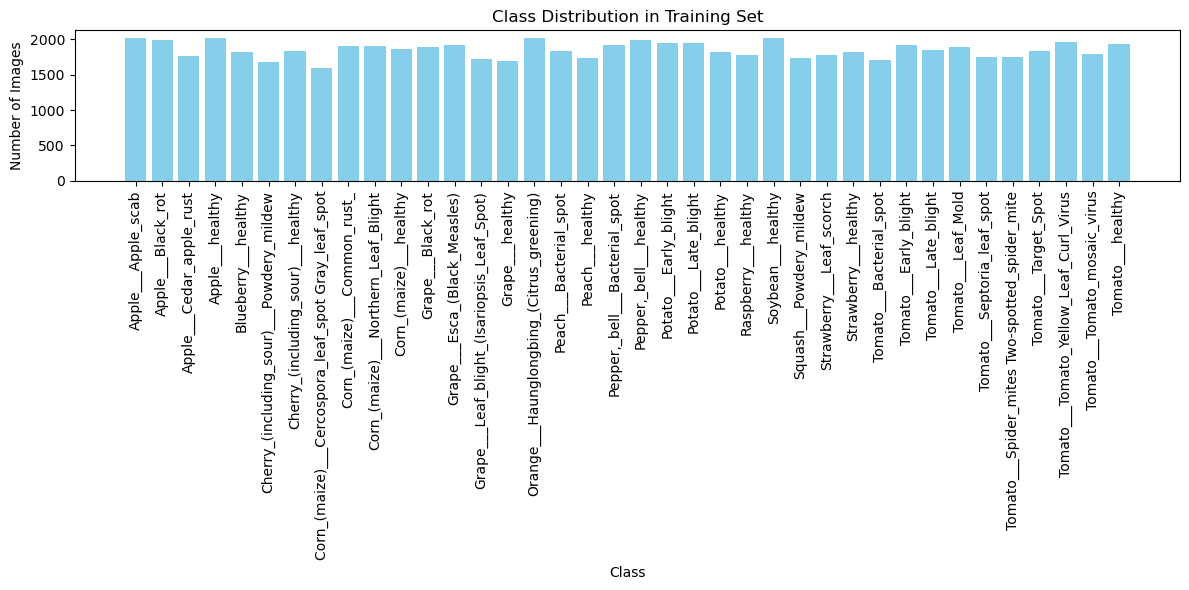

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder

# Load dataset
dataset = ImageFolder(train_dir)

# Get class labels
class_names = dataset.classes

# Count occurrences of each class
labels = [sample[1] for sample in dataset.samples]
counts = Counter(labels)

# Map label indices to class names
class_counts = {class_names[i]: count for i, count in counts.items()}

# Sort by class name or count (optional)
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [6]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [8]:

# Model
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)
model = model.to(device)

In [9]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [10]:
# Training loop
epochs = 10
train_accs, val_accs = [], []
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
best_val_f1 = 0.0

In [11]:
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    print(f"\nEpoch {epoch+1}/{epochs}")
    for imgs, labels in tqdm(train_loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = correct / total * 100
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    val_loss_total = 0.0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()

            _, preds = outputs.max(1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_targets, val_preds, average='macro')
    val_acc = 100.0 * sum([p == t for p, t in zip(val_preds, val_targets)]) / len(val_targets)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    val_losses.append(val_loss_total / len(val_loader))

    print(f"Loss: {total_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Acc: {val_acc:.2f}% - Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "PlantDiseaseResNetModel.pth")
        print(f"✅ Saved new best model at epoch {epoch+1} with Val F1: {val_f1:.4f}")


Epoch 1/10


Loss: 1759.0124 - Train Acc: 63.18% - Val Acc: 92.13% - Val F1: 0.9202
✅ Saved new best model at epoch 1 with Val F1: 0.9202

Epoch 2/10


Loss: 443.3926 - Train Acc: 90.93% - Val Acc: 96.15% - Val F1: 0.9610
✅ Saved new best model at epoch 2 with Val F1: 0.9610

Epoch 3/10


Loss: 245.7693 - Train Acc: 94.65% - Val Acc: 97.77% - Val F1: 0.9773
✅ Saved new best model at epoch 3 with Val F1: 0.9773

Epoch 4/10


Loss: 168.7151 - Train Acc: 96.17% - Val Acc: 98.42% - Val F1: 0.9838
✅ Saved new best model at epoch 4 with Val F1: 0.9838

Epoch 5/10


Loss: 122.9371 - Train Acc: 97.07% - Val Acc: 98.59% - Val F1: 0.9856
✅ Saved new best model at epoch 5 with Val F1: 0.9856

Epoch 6/10


Loss: 97.9994 - Train Acc: 97.71% - Val Acc: 98.88% - Val F1: 0.9885
✅ Saved new best model at epoch 6 with Val F1: 0.9885

Epoch 7/10


Loss: 83.5557 - Train Acc: 97.94% - Val Acc: 99.13% - Val F1: 0.9911
✅ Saved new best model at epoch 7 with Val F1: 0.9911

Epoch 8/10


Loss: 70.5201 - Train Acc: 98.21% - Val Acc: 99.08% - Val F1: 0.9905

Epoch 9/10


Loss: 60.1022 - Train Acc: 98.53% - Val Acc: 99.24% - Val F1: 0.9921
✅ Saved new best model at epoch 9 with Val F1: 0.9921

Epoch 10/10


Loss: 53.2338 - Train Acc: 98.69% - Val Acc: 99.28% - Val F1: 0.9926
✅ Saved new best model at epoch 10 with Val F1: 0.9926


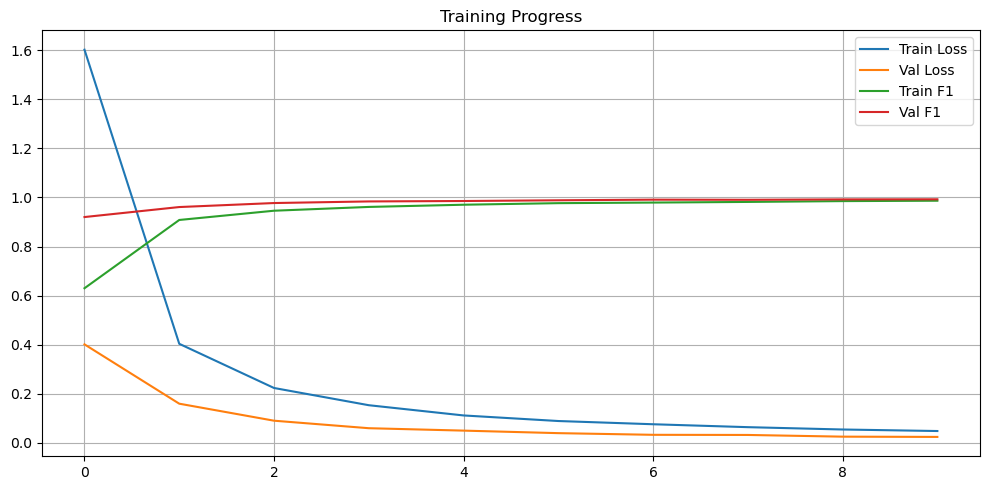

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

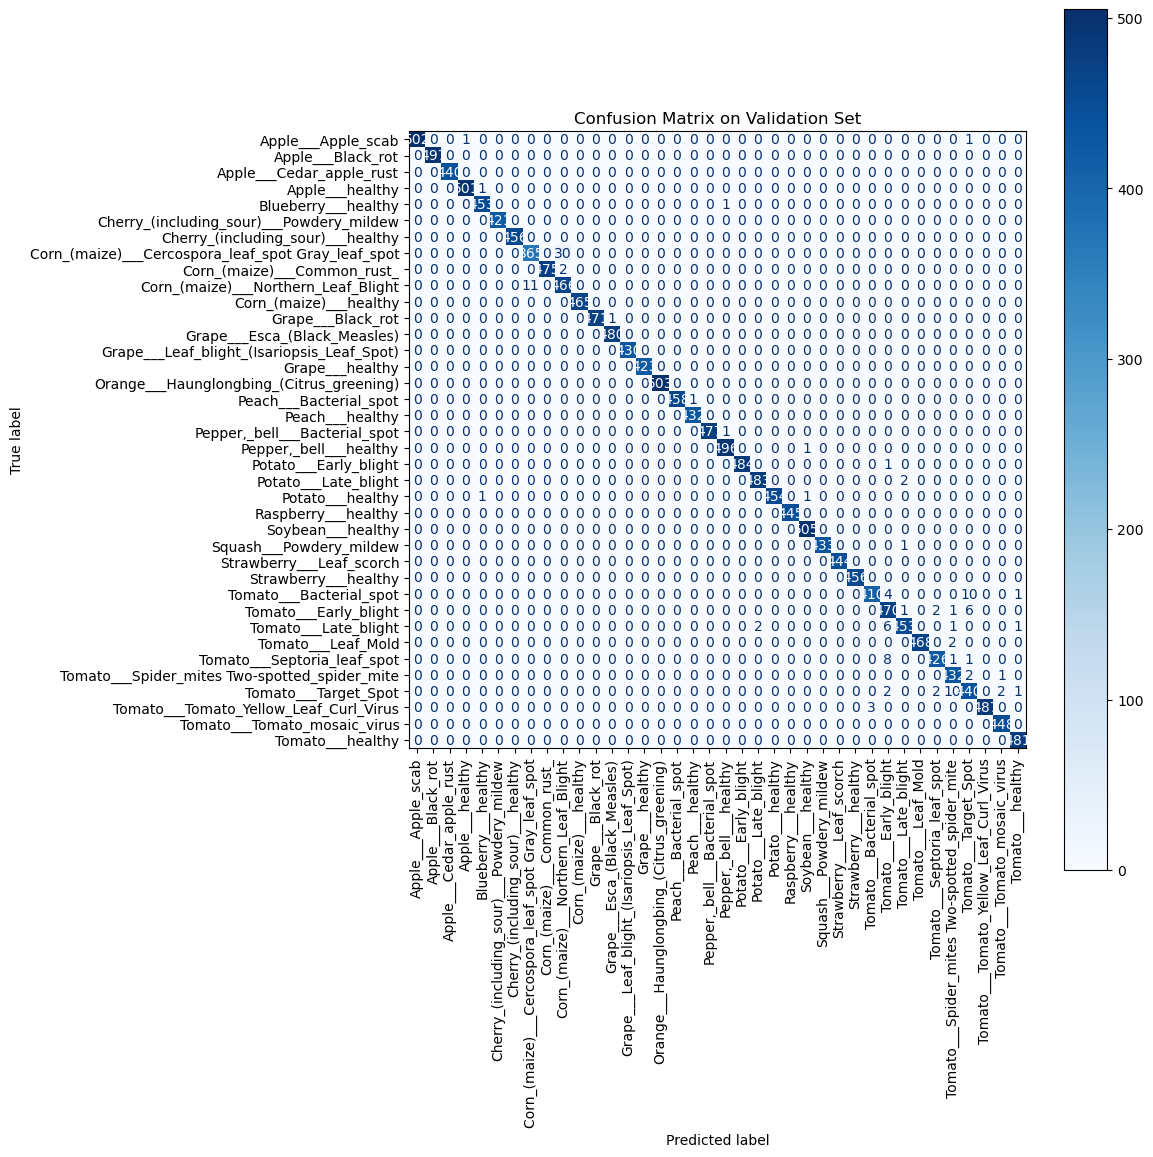

In [14]:
cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix on Validation Set")
plt.tight_layout()
plt.show()

In [2]:
# Direct mapping from original class label to CamelCase label for better readability
label_map = {
    "Apple___Apple_scab": "AppleScab",
    "Apple___Black_rot": "AppleBlackRot",
    "Apple___Cedar_apple_rust": "AppleCedarRust",
    "Apple___healthy": "AppleHealthy",
    "Blueberry___healthy": "BlueberryHealthy",
    "Cherry_(including_sour)___Powdery_mildew": "CherryIncludingSourPowderyMildew",
    "Cherry_(including_sour)___healthy": "CherryIncludingSourHealthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": "CornMaizeCercosporaLeafSpotGrayLeafSpot",
    "Corn_(maize)___Common_rust_": "CornCommonRust",
    "Corn_(maize)___Northern_Leaf_Blight": "CornMaizeNorthernLeafBlight",
    "Corn_(maize)___healthy": "CornMaizeHealthy",
    "Grape___Black_rot": "GrapeBlackRot",
    "Grape___Esca_(Black_Measles)": "GrapeEscaBlackMeasles",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)": "GrapeLeafBlightIsariopsisLeafSpot",
    "Grape___healthy": "GrapeHealthy",
    "Orange___Haunglongbing_(Citrus_greening)": "OrangeHaunglongbingCitrusGreening",
    "Peach___Bacterial_spot": "PeachBacterialSpot",
    "Peach___healthy": "PeachHealthy",
    "Pepper,_bell___Bacterial_spot": "PepperBellBacterialSpot",
    "Pepper,_bell___healthy": "PepperBellHealthy",
    "Potato___Early_blight": "PotatoEarlyBlight",
    "Potato___Late_blight": "PotatoLateBlight",
    "Potato___healthy": "PotatoHealthy",
    "Raspberry___healthy": "RaspberryHealthy",
    "Soybean___healthy": "SoybeanHealthy",
    "Squash___Powdery_mildew": "SquashPowderyMildew",
    "Strawberry___Leaf_scorch": "StrawberryLeafScorch",
    "Strawberry___healthy": "StrawberryHealthy",
    "Tomato___Bacterial_spot": "TomatoBacterialSpot",
    "Tomato___Early_blight": "TomatoEarlyBlight",
    "Tomato___Late_blight": "TomatoLateBlight",
    "Tomato___Leaf_Mold": "TomatoLeafMold",
    "Tomato___Septoria_leaf_spot": "TomatoSeptoriaLeafSpot",
    "Tomato___Spider_mites Two-spotted_spider_mite": "TomatoSpiderMitesTwo-spottedSpiderMite",
    "Tomato___Target_Spot": "TomatoTargetSpot",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "TomatoYellowCurlVirus",
    "Tomato___Tomato_mosaic_virus": "TomatoMosaicVirus",
    "Tomato___healthy": "TomatoHealthy"
}


In [24]:
import torch
from torchvision import models, transforms
from PIL import Image

# --- Config ---
image_path = "images.jpeg"  # Path to test image
model_path = "PlantDiseasePretrainedModel.pth"        # Trained model path


# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Load and Predict ---
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    _, pred = torch.max(output, 1)

pred_class_snake = class_names[pred.item()]
pred_class_camel = label_map[pred_class_snake]
print(f"✅ Predicted Class: {pred_class_camel}")


✅ Predicted Class: SquashPowderyMildew


In [3]:
import os
import re
import torch
import numpy as np
from PIL import Image
from torchvision import models, transforms
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dir = "archive/test/test"
model_path = "PlantDiseasePretrainedModel.pth"

# Map class labels (assuming label_map is defined globally)
camel_class_names = list(label_map.values())
camel_to_index = {label: i for i, label in enumerate(camel_class_names)}
index_to_label = {i: label for label, i in camel_to_index.items()}

# --- Load Model ---
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, len(camel_class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# --- Image Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Evaluation ---
y_true, y_pred = [], []
skipped = 0

for fname in tqdm(os.listdir(test_dir), desc="Evaluating"):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    base = os.path.splitext(fname)[0]
    raw_label = re.sub(r"\d+", "", base).strip().lower()

    matches = [label for label in camel_class_names if raw_label in label.lower()]
    if not matches:
        print(f"⚠️ Skipped {fname} (unknown class label: {raw_label})")
        skipped += 1
        continue

    true_label = matches[0]
    true_idx = camel_to_index[true_label]

    img_path = os.path.join(test_dir, fname)
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Failed to open {fname}: {e}")
        skipped += 1
        continue

    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    pred_idx = pred.item()
    pred_label = index_to_label[pred_idx]

    print(f"Predicted: {pred_label} \t Actual: {true_label}")
    y_true.append(true_idx)
    y_pred.append(pred_idx)

# --- Metrics ---
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n✅ Accuracy: {acc * 100:.2f}%")
print(f"✅ F1 Score: {f1:.4f}")
print(f"🛑 Skipped Images: {skipped}")




Evaluating:  24%|█████████████████▏                                                     | 8/33 [00:00<00:02, 12.13it/s]

Predicted: AppleCedarRust 	 Actual: AppleCedarRust
Predicted: AppleCedarRust 	 Actual: AppleCedarRust
Predicted: AppleCedarRust 	 Actual: AppleCedarRust
Predicted: AppleCedarRust 	 Actual: AppleCedarRust
Predicted: AppleScab 	 Actual: AppleScab
Predicted: AppleScab 	 Actual: AppleScab
Predicted: AppleScab 	 Actual: AppleScab
Predicted: CornCommonRust 	 Actual: CornCommonRust
Predicted: CornCommonRust 	 Actual: CornCommonRust
Predicted: CornCommonRust 	 Actual: CornCommonRust
Predicted: PotatoEarlyBlight 	 Actual: PotatoEarlyBlight
Predicted: PotatoEarlyBlight 	 Actual: PotatoEarlyBlight
Predicted: PotatoEarlyBlight 	 Actual: PotatoEarlyBlight


Evaluating:  67%|██████████████████████████████████████████████▋                       | 22/33 [00:01<00:00, 31.24it/s]

Predicted: PotatoEarlyBlight 	 Actual: PotatoEarlyBlight
Predicted: PotatoEarlyBlight 	 Actual: PotatoEarlyBlight
Predicted: PotatoHealthy 	 Actual: PotatoHealthy
Predicted: PotatoHealthy 	 Actual: PotatoHealthy
Predicted: TomatoEarlyBlight 	 Actual: TomatoEarlyBlight
Predicted: TomatoEarlyBlight 	 Actual: TomatoEarlyBlight
Predicted: TomatoEarlyBlight 	 Actual: TomatoEarlyBlight
Predicted: TomatoEarlyBlight 	 Actual: TomatoEarlyBlight
Predicted: TomatoEarlyBlight 	 Actual: TomatoEarlyBlight
Predicted: TomatoEarlyBlight 	 Actual: TomatoEarlyBlight
Predicted: TomatoHealthy 	 Actual: TomatoHealthy
Predicted: TomatoHealthy 	 Actual: TomatoHealthy
Predicted: TomatoHealthy 	 Actual: TomatoHealthy
Predicted: TomatoHealthy 	 Actual: TomatoHealthy


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 26.22it/s]

Predicted: TomatoYellowCurlVirus 	 Actual: TomatoYellowCurlVirus
Predicted: TomatoYellowCurlVirus 	 Actual: TomatoYellowCurlVirus
Predicted: TomatoYellowCurlVirus 	 Actual: TomatoYellowCurlVirus
Predicted: TomatoYellowCurlVirus 	 Actual: TomatoYellowCurlVirus
Predicted: TomatoYellowCurlVirus 	 Actual: TomatoYellowCurlVirus
Predicted: TomatoYellowCurlVirus 	 Actual: TomatoYellowCurlVirus

✅ Accuracy: 100.00%
✅ F1 Score: 1.0000
🛑 Skipped Images: 0
